# 🚀 Mô Hình Dự Báo Giá Bitcoin Với BiLSTM

Notebook này hướng dẫn bạn từng bước để xây dựng và huấn luyện mô hình dự báo giá Bitcoin.

---

## 📋 Checklist

- [ ] Bước 1: Lấy dữ liệu từ Binance
- [ ] Bước 2: Xử lý dữ liệu
- [ ] Bước 3: Xây dựng model BiLSTM
- [ ] Bước 4: Training model
- [ ] Bước 5: Đánh giá & Vẽ biểu đồ

---

## 💡 Tips

1. Chạy từng cell theo thứ tự từ trên xuống dưới
2. Đọc comments trong code để hiểu
3. Nếu cần giải thích chi tiết, xem `docs/` folder
4. Nghỉ giải lao nếu cảm thấy ngợp!

## 📦 0. Setup & Cấu Hình

Cấu hình TensorFlow và import các thư viện cần thiết.

In [1]:
# Import thư viện
import numpy as np
import pandas as pd
import tensorflow as tf
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Import modules từ project
# Note: Notebook đang chạy từ notebooks/, cần up 1 cấp để tới project root
import sys
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

from utils.runtime import configure_tensorflow_runtime, print_tensorflow_info

# Cấu hình TensorFlow cho CPU AMD
configure_tensorflow_runtime(
    intra_op_threads=12,
    inter_op_threads=2,
    enable_xla=True
)

# In thông tin TensorFlow
print_tensorflow_info()

2025-12-23 19:02:45.852582: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-23 19:02:45.853159: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-23 19:02:45.916573: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-23 19:02:47.930530: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different compu

⚙️  CẤU HÌNH TENSORFLOW RUNTIME
Intra-op threads: 12
Inter-op threads: 2
XLA enabled: True
CPU only: True


📋 THÔNG TIN TENSORFLOW
TensorFlow version: 2.20.0
Keras version: 3.13.0
Built with CUDA: True
ℹ️  Không tìm thấy GPU, sẽ dùng CPU
GPU available: False
Intra-op threads: 12
Inter-op threads: 2



2025-12-23 19:02:49.584295: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## 🔧 1. Cấu Hình Tham Số

Thay đổi các tham số tùy ý:

In [2]:
# ==================== CẤU HÌNH ====================

# Data parameters
SYMBOL = "BTC/USDT"        # Cặp giao dịch
TIMEFRAME = "1d"           # Khung thời gian (1d, 4h, 1h)
LIMIT = 1500                # Số nến lấy từ Binance
REFRESH_CACHE = False       # True = tải lại data, False = dùng cache

# Preprocessing parameters
WINDOW_SIZE = 60            # Số nến nhìn lại (sliding window)
FEATURES = ["close"]       # Features sử dụng

# Model parameters
LSTM_UNITS = [64, 32]       # Số units cho mỗi LSTM layer
DROPOUT_RATE = 0.2         # Dropout rate

# Training parameters
EPOCHS = 20                 # Số epochs
BATCH_SIZE = 32             # Batch size
EARLY_STOPPING_PATIENCE = 5 # Số epochs chờ trước khi dừng

# Print cấu hình
print("="*60)
print("⚙️  CẤU HÌNH")
print("="*60)
print(f"Symbol: {SYMBOL}")
print(f"Timeframe: {TIMEFRAME}")
print(f"Limit: {LIMIT}")
print(f"Window size: {WINDOW_SIZE}")
print(f"Features: {FEATURES}")
print(f"LSTM units: {LSTM_UNITS}")
print(f"Dropout: {DROPOUT_RATE}")
print(f"Epochs: {EPOCHS}")
print(f"Batch size: {BATCH_SIZE}")
print("="*60 + "\n")

⚙️  CẤU HÌNH
Symbol: BTC/USDT
Timeframe: 1d
Limit: 1500
Window size: 60
Features: ['close']
LSTM units: [64, 32]
Dropout: 0.2
Epochs: 20
Batch size: 32



---

## 📥 BƯỚC 1: LẤY DỮ LIỆU TỪ BINANCE

### Giải thích:
- Tải dữ liệu giá từ Binance API
- Cache vào file CSV để lần sau không phải tải lại
- Trả về DataFrame với: datetime, open, high, low, close, volume

In [3]:
from step1_data import fetch_binance_data

# Tải dữ liệu
df = fetch_binance_data(
    symbol=SYMBOL,
    timeframe=TIMEFRAME,
    limit=LIMIT,
    save_cache=not REFRESH_CACHE
)

# In 5 dòng đầu tiên
print("\n📊 5 dòng đầu tiên của dữ liệu:")
print(df.head())

# Thống kê cơ bản
print("\n📊 Thống kê dữ liệu:")
print(df.describe())

# Đánh dấu checklist
print("\n✅ Bước 1 hoàn thành!")

📂 Đang đọc dữ liệu từ cache: /home/ultimatebrok/Downloads/deep_learning/step1_data/cache/BTC_USDT_1d_1500.csv

📊 5 dòng đầu tiên của dữ liệu:
    datetime      open      high       low     close       volume
0 2023-03-30  28348.60  29184.68  27686.00  28028.53  98865.43256
1 2023-03-31  28028.53  28656.69  27511.71  28465.36  78198.12139
2 2023-04-01  28465.36  28819.71  28220.27  28452.73  30238.44753
3 2023-04-02  28452.74  28530.00  27856.43  28171.87  37365.65692
4 2023-04-03  28171.87  28500.99  27200.24  27800.00  79180.01405

📊 Thống kê dữ liệu:
                  datetime           open           high            low  \
count                 1000    1000.000000    1000.000000    1000.000000   
mean   2024-08-10 12:00:00   69008.702190   70231.238270   67751.070900   
min    2023-03-30 00:00:00   25128.600000   25759.010000   24800.000000   
25%    2023-12-04 18:00:00   39815.197500   40287.680000   39392.400000   
50%    2024-08-10 12:00:00   66672.755000   67793.495000   65195.0

### Vẽ biểu đồ lịch sử giá

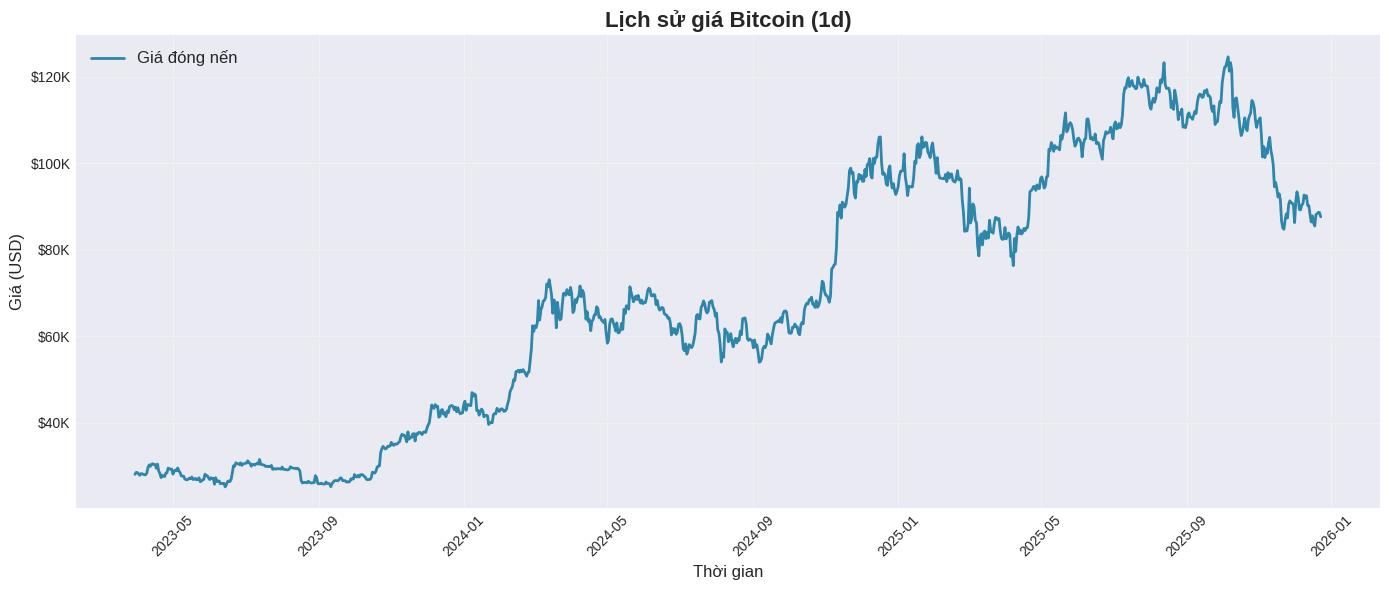

In [4]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

plt.figure(figsize=(14, 6))
plt.plot(df['datetime'], df['close'], linewidth=2, color='#2E86AB', label='Giá đóng nến')
plt.title(f'Lịch sử giá Bitcoin ({TIMEFRAME})', fontsize=16, fontweight='bold')
plt.xlabel('Thời gian', fontsize=12)
plt.ylabel('Giá (USD)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
plt.tight_layout()
plt.show()

---

## 🔨 BƯỚC 2: XỬ LÝ DỮ LIỆU

### Giải thích:
- **Scaling**: Đưa dữ liệu về khoảng [0, 1] để model học tốt hơn
- **Sliding Window**: Tạo sequences (60 ngày trước → dự đoán ngày tiếp theo)
- **Split Data**: Chia thành train (80%), val (10%), test (10%)

In [5]:
from step2_preprocessing import prepare_data_for_lstm

# Pipeline xử lý dữ liệu hoàn chỉnh
data_dict = prepare_data_for_lstm(
    df=df,
    features=FEATURES,
    window_size=WINDOW_SIZE,
    scaler_type='minmax'
)

# Lấy các biến
X_train = data_dict['X_train']
y_train = data_dict['y_train']
X_val = data_dict['X_val']
y_val = data_dict['y_val']
X_test = data_dict['X_test']
y_test = data_dict['y_test']
scaler = data_dict['scaler']

# Đánh dấu checklist
print("\n✅ Bước 2 hoàn thành!")

📦 Dữ liệu gốc shape: (1000, 1)
✅ Đã fit và transform dữ liệu với minmax scaler
   Min: 0.0000, Max: 1.0000
✅ Đã tạo 940 windows:
   X shape: (940, 60, 1) (samples, window_size, features)
   y shape: (940, 1, 1) (samples, predict_steps)
📊 Chia dữ liệu:
   Train: 752 samples (80.0%)
   Val: 94 samples (10.0%)
   Test: 94 samples (9.999999999999995%)

✅ Bước 2 hoàn thành!


### Kiểm tra shapes của dữ liệu

In [6]:
print("\n" + "="*60)
print("📊 SHAPES CỦA DỮ LIỆU")
print("="*60)
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_val:   {X_val.shape}")
print(f"y_val:   {y_val.shape}")
print(f"X_test:  {X_test.shape}")
print(f"y_test:  {y_test.shape}")
print("="*60 + "\n")


📊 SHAPES CỦA DỮ LIỆU
X_train: (752, 60, 1)
y_train: (752, 1, 1)
X_val:   (94, 60, 1)
y_val:   (94, 1, 1)
X_test:  (94, 60, 1)
y_test:  (94, 1, 1)



---

## 🧠 BƯỚC 3: XÂY DỰNG MODEL BiLSTM

### Giải thích:
- **BiLSTM**: LSTM hai chiều (nhìn cả quá khứ và tương lai)
- **Dropout**: Bỏ ngẫu nhiên neurons để tránh overfitting
- **Dense layers**: Kết hợp features để đưa ra dự đoán

In [7]:
from step3_model import build_bilstm_model, print_model_summary

# Xây dựng model
input_shape = (WINDOW_SIZE, len(FEATURES))
model = build_bilstm_model(
    input_shape=input_shape,
    lstm_units=LSTM_UNITS,
    dropout_rate=DROPOUT_RATE,
    dense_units=[16],
    output_units=1
)

# In thông tin model
print_model_summary(model)

# Đánh dấu checklist
print("\n✅ Bước 3 hoàn thành!")

2025-12-23 19:02:50.681818: I external/local_xla/xla/service/service.cc:163] XLA service 0x3a56d1f0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-12-23 19:02:50.681854: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): Host, Default Version


✅ Đã build model BiLSTM với 2 LSTM layers

MODEL SUMMARY


Model: "BiLSTM_Price_Prediction"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 60, 128)        │        33,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_dropout_1 (Dropout)       │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,065 (297.13 KB)

 Trainable params: 76,065 (297.13 KB)

 Non-trainable params: 0 (0.00 B)


📊 Thống kê:
   Total parameters: 76,065
   Trainable: 76,065
   Non-trainable: 0

✅ Bước 3 hoàn thành!


---

## 🏋️ BƯỚC 4: TRAINING MODEL

### Giải thích:
- **ModelCheckpoint**: Lưu lại model tốt nhất
- **EarlyStopping**: Dừng nếu val_loss không giảm
- **ReduceLROnPlateau**: Giảm learning rate nếu không cải thiện

In [8]:
from step4_training import train_model

# Training
train_result = train_model(
    model=model,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    early_stopping_patience=EARLY_STOPPING_PATIENCE
)

# Lấy training history
history = train_result['history']

# Đánh dấu checklist
print("\n✅ Bước 4 hoàn thành!")


🚀 BẮT ĐẦU TRAINING
Epochs: 20
Batch size: 32
Train samples: 752
Val samples: 94
Checkpoint: /home/ultimatebrok/Downloads/deep_learning/reports/checkpoints/best_model.keras

Epoch 1/20


2025-12-23 19:02:54.985931: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


 1/24 ━━━━━━━━━━━━━━━━━━━━ 2:22 6s/step - loss: 0.1250 - mae: 0.2851

I0000 00:00:1766491377.224759  472515 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.0516 - mae: 0.1653
Epoch 1: val_loss improved from None to 0.00239, saving model to /home/ultimatebrok/Downloads/deep_learning/reports/checkpoints/best_model.keras

Epoch 1: finished saving model to /home/ultimatebrok/Downloads/deep_learning/reports/checkpoints/best_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 212ms/step - loss: 0.0302 - mae: 0.1244 - val_loss: 0.0024 - val_mae: 0.0401 - learning_rate: 0.0010
Epoch 2/20
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0113 - mae: 0.0777
Epoch 2: val_loss did not improve from 0.00239
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0104 - mae: 0.0726 - val_loss: 0.0074 - val_mae: 0.0795 - learning_rate: 0.0010
Epoch 3/20
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0087 - mae: 0.0652
Epoch 3: val_loss did not improve from 0.00239
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0088 - mae: 0.0668 - val_loss: 0.0176 - val_mae: 0.1291 - learning_rate: 0.0010
Epoch 4/20
23/24 ━━━━━━━

### Vẽ biểu đồ training history

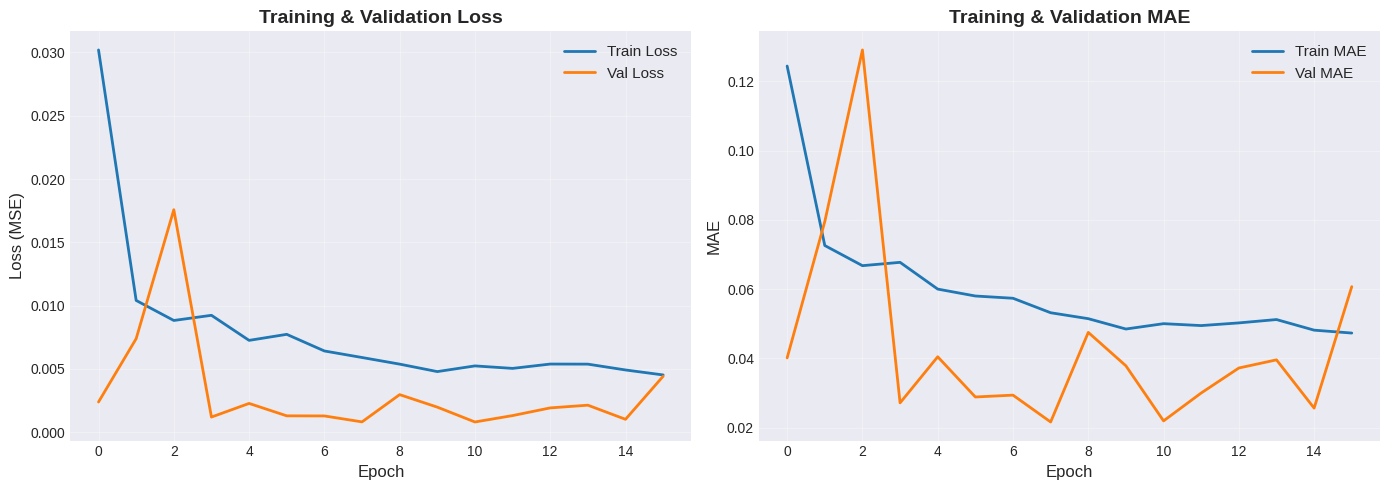

In [9]:
from step5_visualization import plot_training_history

plot_training_history(history)

---

## 📊 BƯỚC 5: ĐÁNH GIÁ & VẼ BIỂU ĐỒ

### Giải thích:
- **MAE**: Sai số trung bình tuyệt đối (USD)
- **RMSE**: Căn bậc 2 của sai số bình phương trung bình (USD)
- **MAPE**: Sai số phần trăm trung bình (%)

In [10]:
from step4_training import evaluate_model, print_sample_predictions, calculate_direction_accuracy
from step5_visualization import plot_predictions, plot_all_in_one

# Đánh giá trên test set
eval_result = evaluate_model(
    model=model,
    X_test=X_test,
    y_test=y_test,
    scaler=scaler,
    return_predictions=True
)

# Lấy dự đoán và giá trị thật
y_true = eval_result['y_true']
y_pred = eval_result['predictions']


📊 KẾT QUẢ ĐÁNH GIÁ TRÊN TEST SET
MAE:  $4610.29  (Sai số trung bình tuyệt đối)
RMSE: $5530.78  (Căn bậc 2 sai số bình phương)
MAPE: 4.62%  (Sai số phần trăm trung bình)



In [11]:
# In một số ví dụ dự đoán
print_sample_predictions(y_true, y_pred, n_samples=10)


VÍ DỤ DỰ ĐOÁN (đầu 10 mẫu)
STT   Thực tế         Dự đoán         Sai số          % Sai số  
------------------------------------------------------------
1     $115232.29     $116965.89     $1733.60       1.50     %
2     $112650.99     $117045.31     $4394.32       3.90     %
3     $111998.80     $116815.63     $4816.83       4.30     %
4     $113307.00     $116469.12     $3162.12       2.79     %
5     $108994.49     $116219.91     $7225.42       6.63     %
6     $109643.46     $115528.38     $5884.92       5.37     %
7     $109635.85     $114893.95     $5258.10       4.80     %
8     $112163.95     $114280.62     $2116.68       1.89     %
9     $114311.96     $113965.31     $346.65        0.30     %
10    $114048.93     $113939.84     $109.09        0.10     %



In [12]:
# Tính độ chính xác xu hướng
calculate_direction_accuracy(y_true, y_pred)

📈 Độ chính xác xu hướng: 47.31%


np.float64(0.4731182795698925)

### Vẽ biểu đồ predictions vs actual

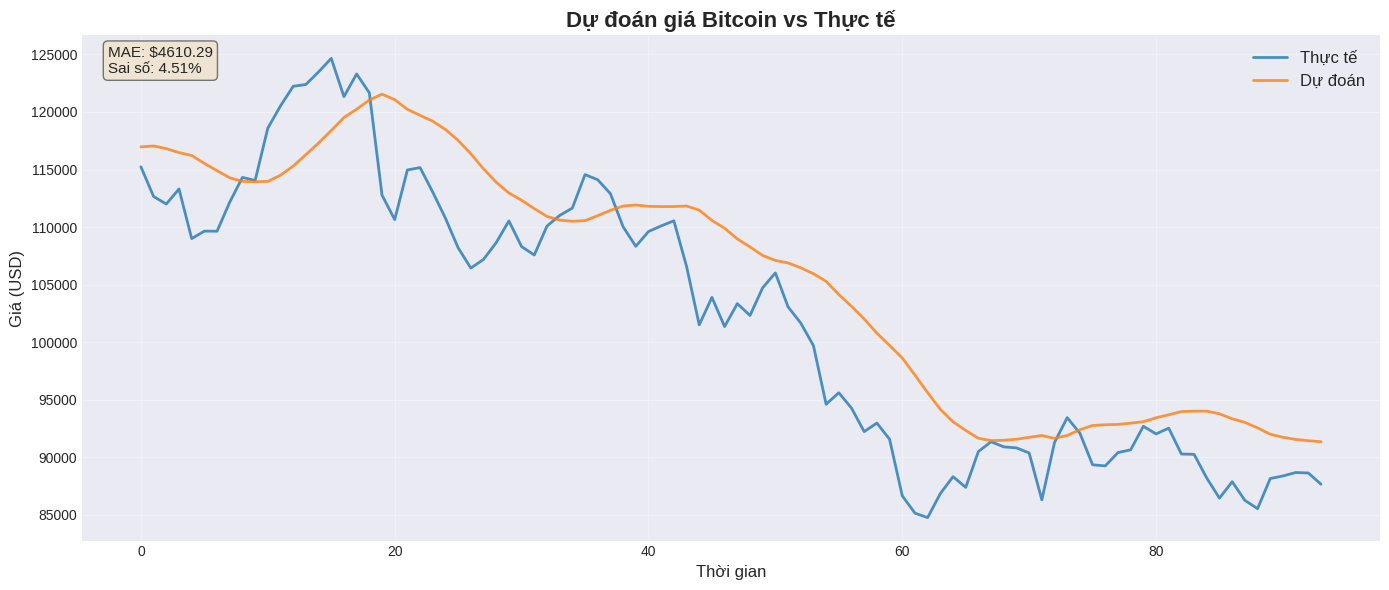

In [13]:
plot_predictions(y_true, y_pred)

### Vẽ biểu đồ tổng hợp (all-in-one)

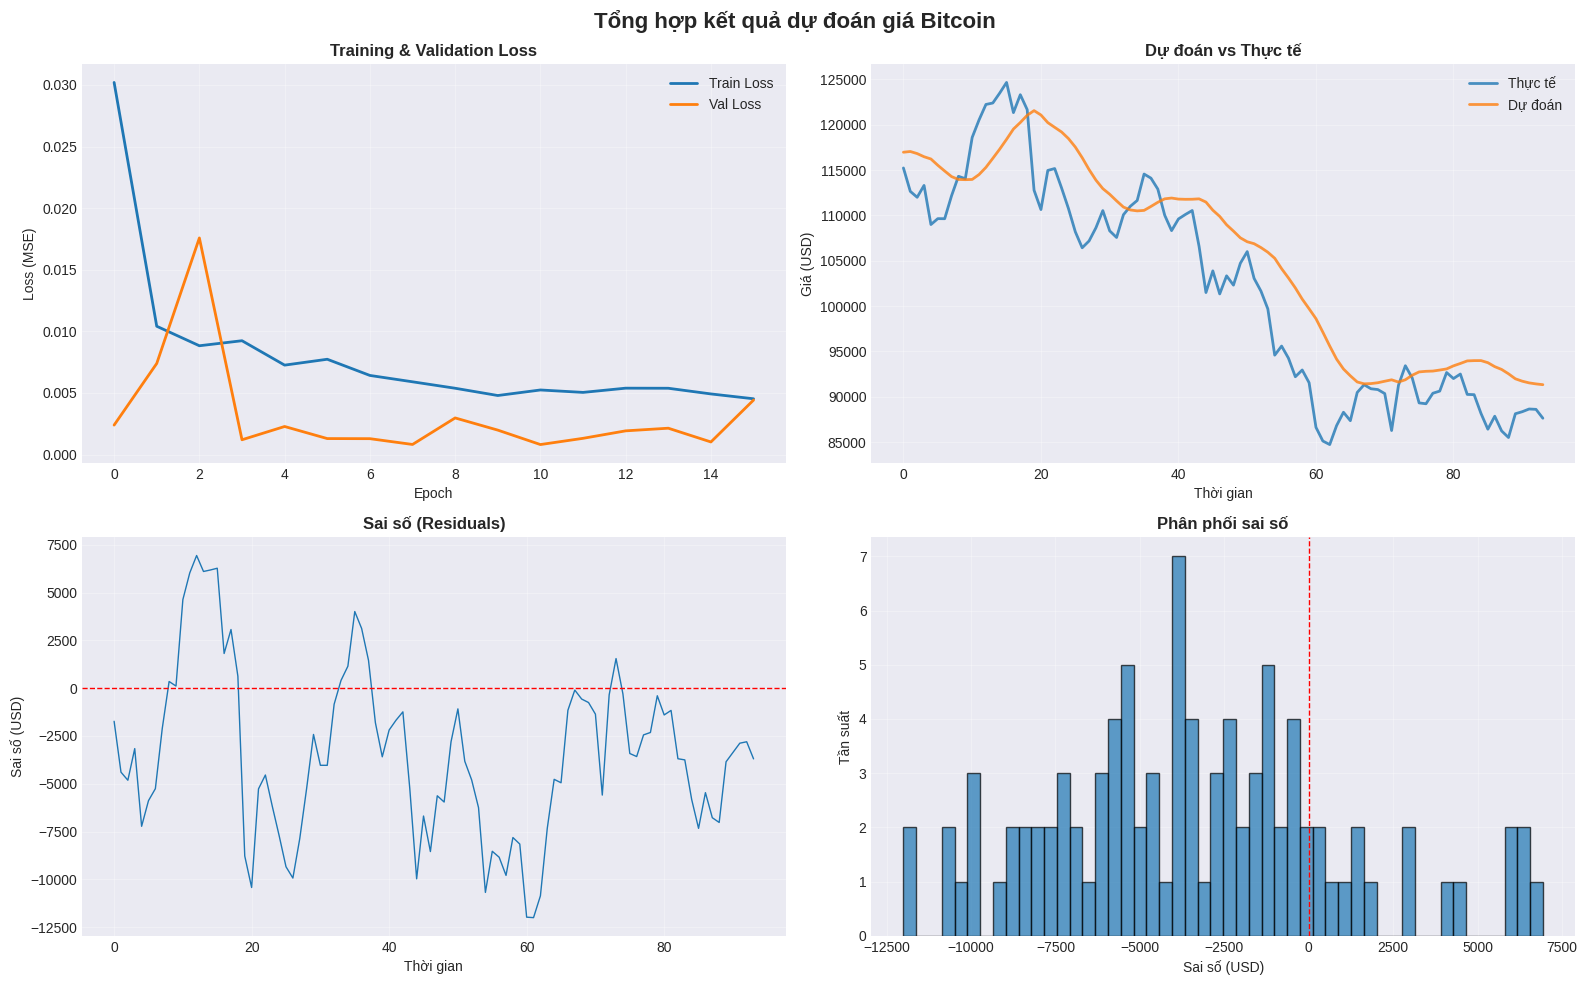

In [14]:
plot_all_in_one(history, y_true, y_pred)

---

## 💾 LƯU KẾT QUẢ

Tất cả kết quả được lưu vào thư mục `reports/notebook/`

📁 Folder kết quả: /home/ultimatebrok/Downloads/deep_learning/reports/notebook/BiLSTM_20251223_190322

💾 Đã lưu training history plot: /home/ultimatebrok/Downloads/deep_learning/reports/notebook/BiLSTM_20251223_190322/training_history_20251223_190322.png


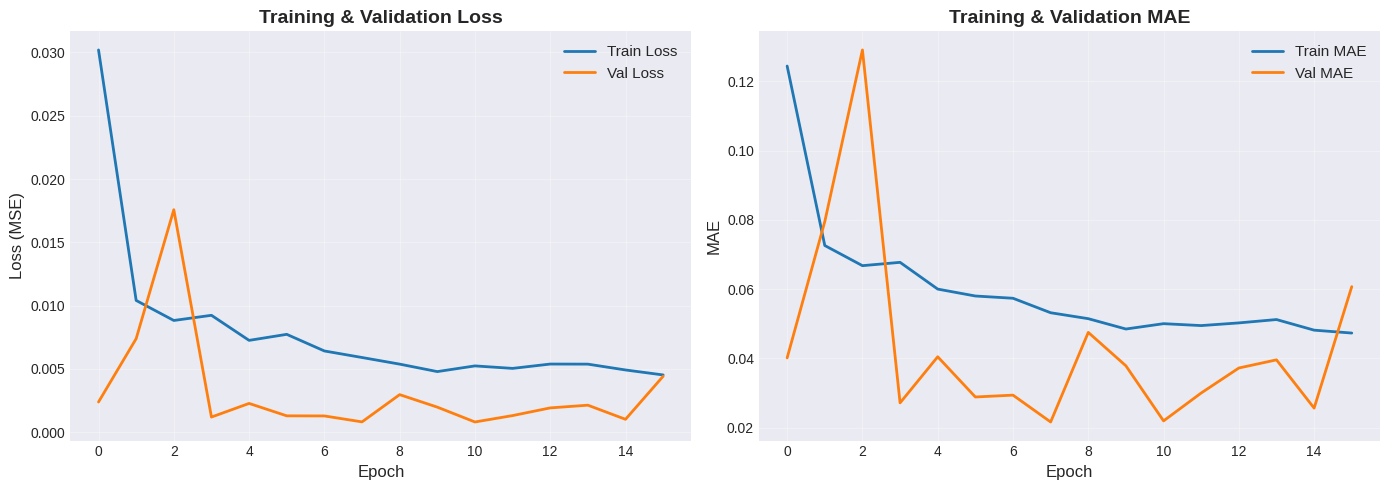

💾 Đã lưu predictions plot: /home/ultimatebrok/Downloads/deep_learning/reports/notebook/BiLSTM_20251223_190322/predictions_20251223_190322.png


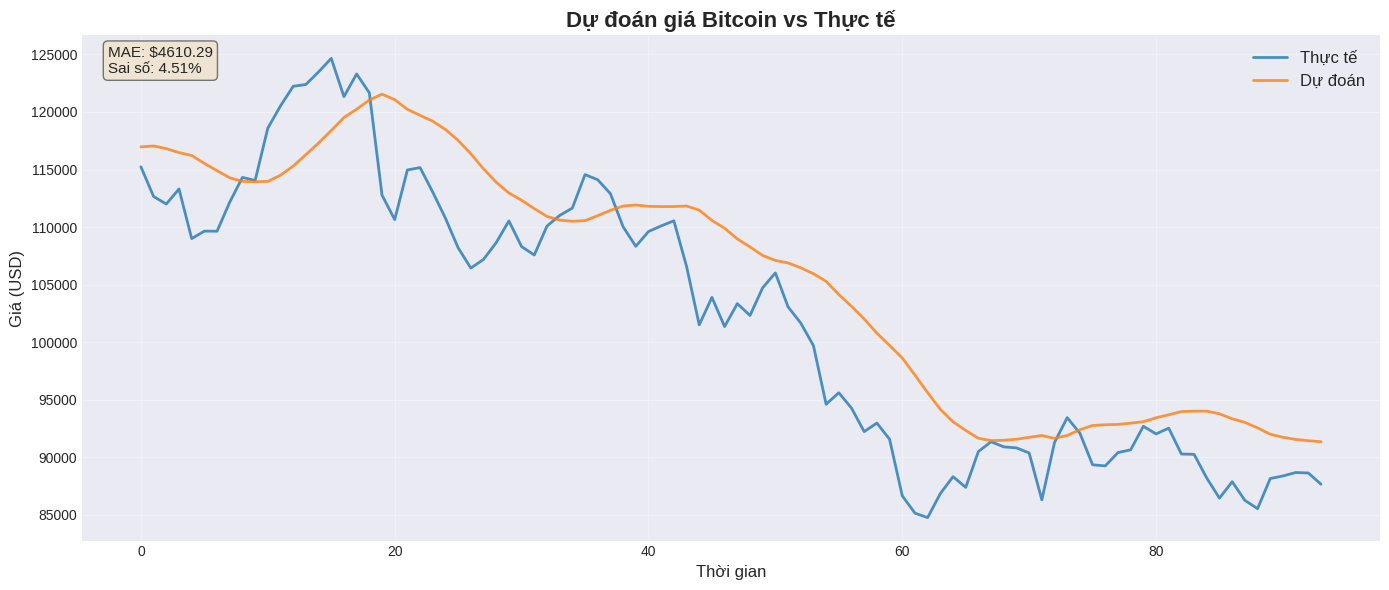

💾 Đã lưu all-in-one plot: /home/ultimatebrok/Downloads/deep_learning/reports/notebook/BiLSTM_20251223_190322/all_in_one_20251223_190322.png


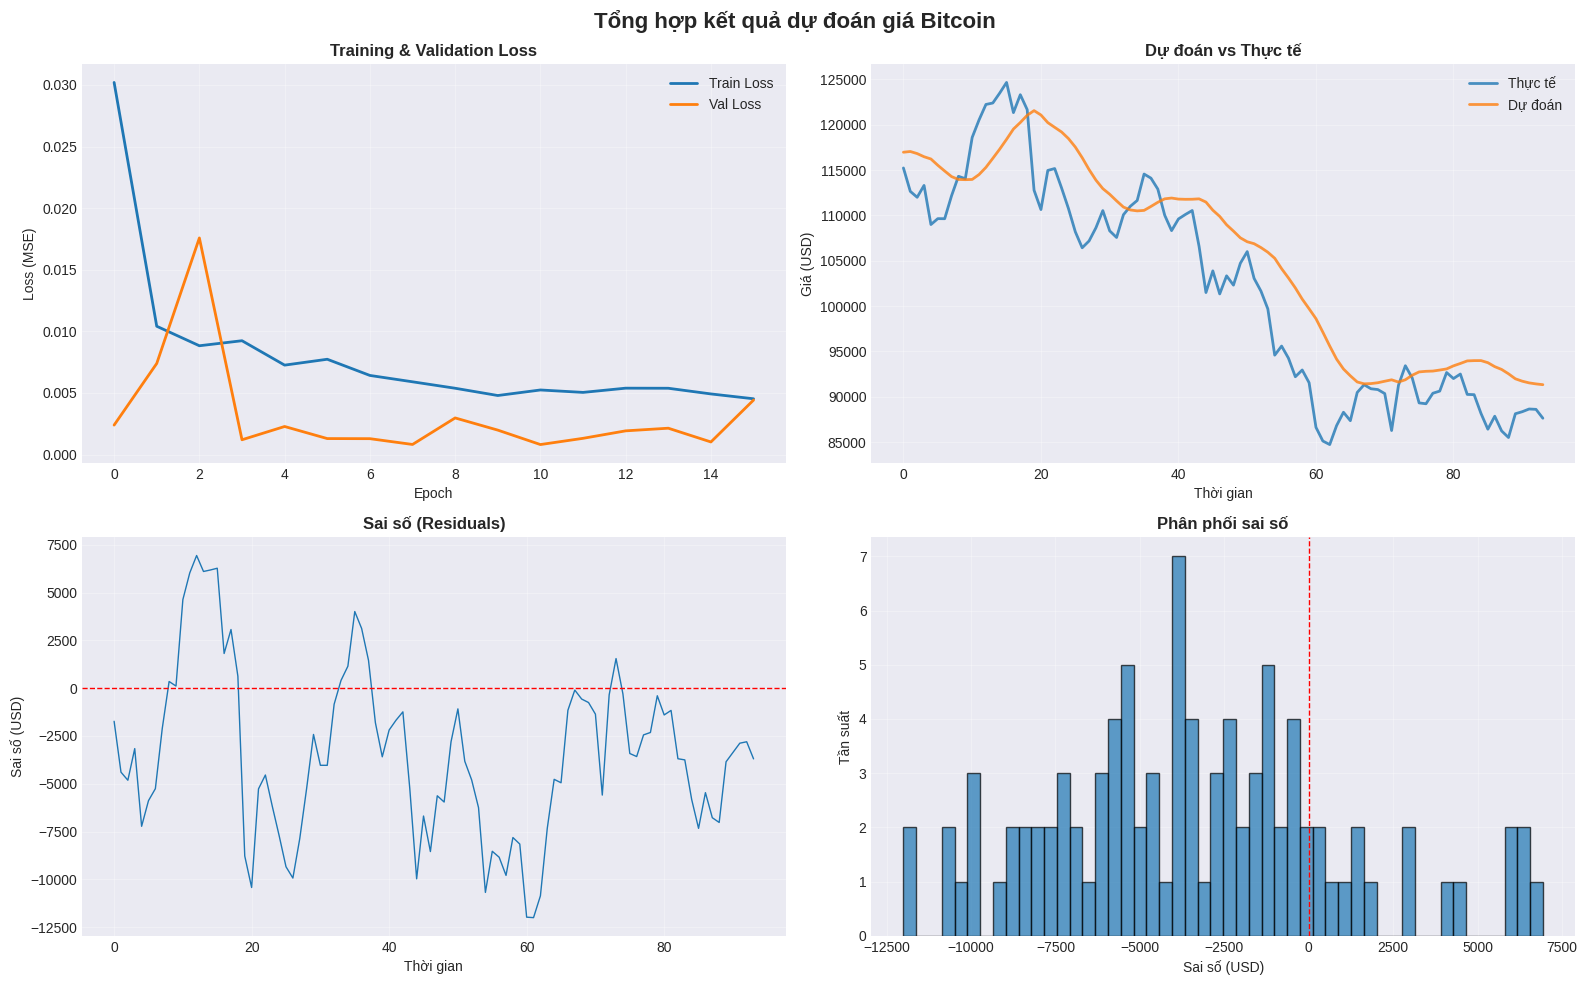

💾 Đã lưu báo cáo Markdown: /home/ultimatebrok/Downloads/deep_learning/reports/notebook/BiLSTM_20251223_190322/results_BiLSTM_20251223_190322.md
💾 Đã lưu cấu hình: /home/ultimatebrok/Downloads/deep_learning/reports/notebook/BiLSTM_20251223_190322/config.json
💾 Đã lưu metrics: /home/ultimatebrok/Downloads/deep_learning/reports/notebook/BiLSTM_20251223_190322/metrics.json

✅ Bước 5 hoàn thành!


In [15]:
from utils import create_results_folder, save_markdown_report, save_config, save_metrics

# Tạo folder kết quả
results_folder = create_results_folder(run_type="notebook")
print(f"📁 Folder kết quả: {results_folder}\n")

# Tạo suffix cho tên file
timestamp_suffix = results_folder.name.replace('BiLSTM_', '')

# Vẽ và lưu biểu đồ
plot_history_file = results_folder / f"training_history_{timestamp_suffix}.png"
plot_predictions_file = results_folder / f"predictions_{timestamp_suffix}.png"
plot_all_in_one_file = results_folder / f"all_in_one_{timestamp_suffix}.png"

plot_training_history(history, save_path=str(plot_history_file))
plot_predictions(y_true, y_pred, save_path=str(plot_predictions_file))
plot_all_in_one(history, y_true, y_pred, save_path=str(plot_all_in_one_file))

# Chuẩn bị config và metrics
config_dict = {
    'symbol': SYMBOL,
    'timeframe': TIMEFRAME,
    'limit': LIMIT,
    'window_size': WINDOW_SIZE,
    'features': FEATURES,
    'lstm_units': LSTM_UNITS,
    'dropout_rate': DROPOUT_RATE,
    'epochs': EPOCHS,
    'batch_size': BATCH_SIZE,
    'early_stopping_patience': EARLY_STOPPING_PATIENCE
}

plots_dict = {
    'training_history': timestamp_suffix,
    'predictions': timestamp_suffix,
    'all_in_one': timestamp_suffix
}

# Lưu báo cáo
save_markdown_report(
    folder_path=results_folder,
    config=config_dict,
    metrics=eval_result,
    history=history.history,
    plots=plots_dict
)
save_config(results_folder, config_dict)
save_metrics(results_folder, eval_result)

# Đánh dấu checklist
print("\n✅ Bước 5 hoàn thành!")

---

## 🎉 HOÀN THÀNH!

### Checklist:
- [x] Bước 1: Lấy dữ liệu từ Binance
- [x] Bước 2: Xử lý dữ liệu
- [x] Bước 3: Xây dựng model BiLSTM
- [x] Bước 4: Training model
- [x] Bước 5: Đánh giá & Vẽ biểu đồ

### Kết quả:
- Báo cáo Markdown: `reports/notebook/BiLSTM_YYYYMMDD_HHMMSS/results_*.md`
- Biểu đồ: Các file PNG trong cùng folder
- Config & Metrics: File JSON trong cùng folder

### Tiếp theo:
- Thử thay đổi các tham số (window size, LSTM units, v.v.)
- Thêm các features khác (volume, open, high, low)
- Thử timeframe khác (4h, 1h)

**Chúc bạn thành công! 🚀**